In [193]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Descomprimir y separar los datos en entrenamineto, validación y prueba

In [194]:
# !unzip '/content/drive/MyDrive/Mini-Proyecto/MINI-DDSM-Complete-JPEG-8-ordenado_x_carpetas.zip' -d '/content/drive/MyDrive/Mini-Proyecto/'

In [195]:
# !pip install split-folders

In [1]:
# import splitfolders

In [2]:
# img_entrada = 'C:/Git/python/MCD-PCD/MiniProyecto2/dataset'

In [3]:
# splitfolders.ratio(img_entrada, output = 'C:/Git/python/MCD-PCD/MiniProyecto2/dataset',
#                   seed = 42, ratio = (0.7, 0.2, 0.1),
#                   group_prefix = None)

Copying files: 3907 files [03:23, 19.24 files/s]


## Procesamiento

In [199]:
# !pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from PIL import Image
from PIL import ImageFont
from time import time
from statistics import mean

In [33]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import (Dense, Dropout, Conv2D, Flatten, AveragePooling2D, BatchNormalization,
                          Activation, MaxPooling2D, ZeroPadding2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import  ReduceLROnPlateau

from tensorflow.keras.applications import Xception

from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve,
                             ConfusionMatrixDisplay, f1_score, precision_recall_curve, recall_score, precision_score)

from keras.utils.vis_utils import plot_model
import visualkeras
from collections import defaultdict

In [34]:
direccion_entrenamiento = 'C:/Git/python/MCD-PCD/MiniProyecto2/dataset/train'
direccion_validacion = 'C:/Git/python/MCD-PCD/MiniProyecto2/dataset/val'
direccion_prueba = 'C:/Git/python/MCD-PCD/MiniProyecto2/dataset/test'

In [35]:
def conteo_datos(direccion_archivo):
    conteo_clase = {}
    conteo_total = 0
    if 'pred' in direccion_archivo:
        return len(os.listdir(os.path.join(direccion_archivo))), conteo_clase
    else:
        for nombre_clase in os.listdir(os.path.join(direccion_archivo)):
            conteo = len(os.listdir(os.path.join(direccion_archivo, nombre_clase)))
            conteo_clase[nombre_clase] = conteo
            conteo_total += conteo
    return conteo_total, conteo_clase

In [36]:
conteo_entrenamiento, conteo_clase_entrenamiento = conteo_datos(direccion_entrenamiento)
conteo_validacion, conteo_clase_validacion = conteo_datos(direccion_validacion)
conteo_prueba, conteo_clase_prueba = conteo_datos(direccion_prueba)

print('Tamaño de datos de entrenamiento: ', conteo_entrenamiento, conteo_clase_entrenamiento)
print('Tamaño de datos de validación: ', conteo_validacion, conteo_clase_validacion)
print('Tamaño de datos de prueba: ', conteo_prueba, conteo_clase_prueba)

Tamaño de datos de entrenamiento:  2732 {'Benigno': 939, 'Cancer': 951, 'Normal': 842}
Tamaño de datos de validación:  780 {'Benigno': 268, 'Cancer': 272, 'Normal': 240}
Tamaño de datos de prueba:  394 {'Benigno': 135, 'Cancer': 137, 'Normal': 122}


In [37]:
# Checar dimensiones
dim1 = []
dim2 = []

subcarpetas = ['/Normal', '/Benigno', '/Cancer']
#etiquetas_imagenes = ['Organico', 'Reciclable']
carpeta = os.listdir(direccion_entrenamiento)

for i in subcarpetas:
  for j in os.listdir(direccion_entrenamiento + i):
    aux = direccion_entrenamiento + i
    aux2 = aux + '/'
    img = Image.open(aux2 + j)
    d1, d2 = img.size
    dim1.append(d1)
    dim2.append(d2)

print(mean(dim1))
print(mean(dim2))

1568.5161054172768
2712.794655929722


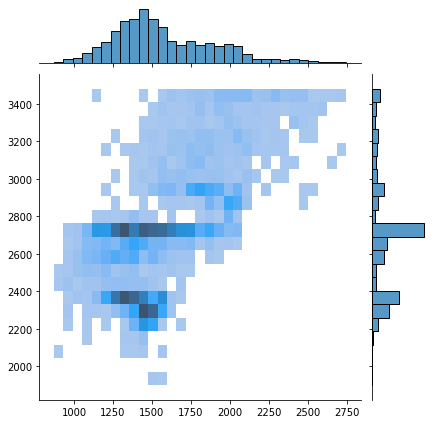

In [38]:
sns.jointplot(x=dim1,y=dim2, kind='hist')

In [39]:
Nuevas_imagenes_entrenamineto = ImageDataGenerator(rescale = 1/255, # Normaliza las imágenes
                                                   horizontal_flip = True, # Voltea aleatoriamente las imágenes horizontalmente
                                                   vertical_flip = True, # Voltea aleatoriamente las imágenes verticalmente
                                                   )

Nuevas_imagenes_validacion = ImageDataGenerator(rescale = 1/255, # Normaliza las imágenes
                                                )


Nuevas_imagenes_prueba = ImageDataGenerator(rescale = 1/255 # Normaliza las imágenes
                                            )

In [40]:
# Cambiando aleatoriamente las imágenes
altura = 299
ancho = 299
batch_size = 16

Entrenamiento = Nuevas_imagenes_entrenamineto.flow_from_directory(direccion_entrenamiento, # Carpeta donde se encuentran las imágenes
                                                                  target_size = (altura, ancho), # Reescalando el tamaño de las imágenes
                                                                  batch_size = batch_size, # Tamaño del batch size
                                                                  class_mode = 'categorical', # Tipo de variable
                                                                  color_mode = 'rgb', # Canal de la imagen
                                                                  shuffle = True, # Mezclar las imágenes
                                                                  classes = ['Normal', 'Benigno', 'Cancer'] # Etiqueta de las clases
                                                                  )

Validacion = Nuevas_imagenes_validacion.flow_from_directory(direccion_validacion, # Carpeta donde se encuentran las imágenes
                                                            target_size = (altura, ancho), # Reescalando el tamaño de las imágenes
                                                            batch_size = batch_size, # Tamaño del batch size
                                                            class_mode = 'categorical', # Tipo de variable
                                                            color_mode = 'rgb', # Canal de la imagen
                                                            shuffle = False, # Mezclar las imágenes
                                                            classes = ['Normal', 'Benigno', 'Cancer'] # Etiqueta de las clases
                                                            )

Prueba = Nuevas_imagenes_prueba.flow_from_directory(direccion_prueba, # Carpeta donde se encuentran las imágenes
                                                    target_size = (altura, ancho), # Reescalando el tamaño de las imágenes
                                                    batch_size = batch_size, # Tamaño del batch size
                                                    class_mode = 'categorical', # Tipo de variable
                                                    color_mode = 'rgb', # Canal de la imagen
                                                    shuffle = False, # Mezclar las imágenes
                                                    classes = ['Normal', 'Benigno', 'Cancer'] # Etiqueta de las clases
                                                    )

Found 2732 images belonging to 3 classes.
Found 779 images belonging to 3 classes.
Found 394 images belonging to 3 classes.


In [11]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8036379/#:~:text=Transfer%20Learning%20for%20Medical%20Imaging,9%2C10%2C24%5D.

In [41]:
# Construcción del modelo
modelo = Xception(weights = 'imagenet', include_top = False, input_shape = (altura, ancho, 3))

In [13]:
#for layer in modelo.layers:
#  layer.trainable = False
  
# Make sure you have frozen the correct layers
#for i, layer in enumerate(modelo.layers):
#  print(i, layer.name, layer.trainable)

In [42]:
modelo2 = Sequential()
modelo2.add(modelo)
modelo2.add(Flatten())
modelo2.add(Dense(256))
modelo2.add(BatchNormalization())
modelo2.add(Activation('relu'))
modelo2.add(Dropout(0.5))
modelo2.add(Dense(512))
modelo2.add(BatchNormalization())
modelo2.add(Activation('relu'))
modelo2.add(Dropout(0.5))
modelo2.add(Dense(3))
modelo2.add(Activation('softmax'))

In [43]:
# Métricas
metricas = [tf.keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy'),
            tf.keras.metrics.Precision(name = 'precision'),
            tf.keras.metrics.Recall(name = 'recall'),
            tf.keras.metrics.AUC(name = 'auc')]

# Función de perdida y el optimizador
modelo2.compile(loss = tf.keras.losses.CategoricalCrossentropy(name = 'categorical_crossentropy'),
               optimizer = 'adam',
               metrics = metricas)

In [16]:
# Resumen del modelo InceptionResNetV2
#modelo.summary()

In [17]:
# Resumen del modelo final
#modelo2.summary()

In [44]:
plot_model(modelo2, to_file = 'C:/Git/python/MCD-PCD/MiniProyecto2/modelo_1_InceptionResNetV2.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


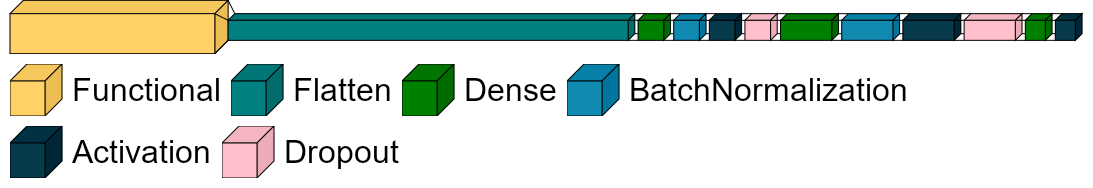

In [45]:
#https://github.com/paulgavrikov/visualkeras/

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'pink'
color_map[Dense]['fill'] = 'green'
color_map[Flatten]['fill'] = 'teal'

visualkeras.layered_view(modelo2, to_file = 'C:/Git/python/MCD-PCD/MiniProyecto2/modelo_1v2_InceptionResNetV2.png').show()
font = ImageFont.truetype('C:/Git/python/MCD-PCD/Tarea 06/arial.ttf', 32)
visualkeras.layered_view(modelo2, legend = True, font = font, color_map = color_map)

In [46]:
# Entrener el modelo
Inicio = time()

reducir_ta = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 1e-5)

ksst = modelo2.fit(Entrenamiento, epochs = 3, validation_data = Validacion, callbacks = [reducir_ta])

Final = time()
Tiempo_total = Final - Inicio

print('\nTiempo de entrenamiento: {:.0f}h {:.0f}m {:.0f}s.'.format(Tiempo_total // (60 * 60),
                                                                   Tiempo_total // 60,
                                                                   Tiempo_total % 60))

Epoch 1/3
  1/171 [..............................] - ETA: 2:16:20 - loss: 1.7258 - categorical_accuracy: 0.3750 - precision: 0.3333 - recall: 0.2500 - auc: 0.4766

KeyboardInterrupt: 

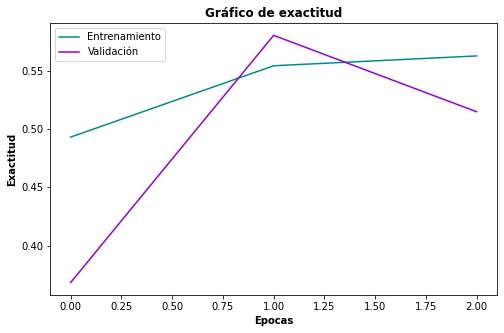

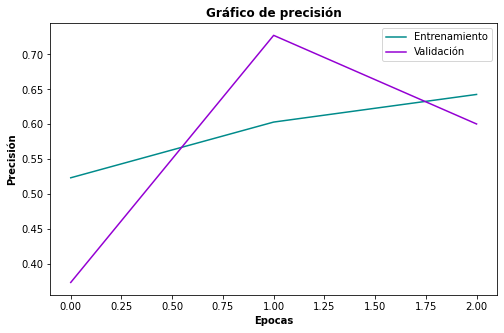

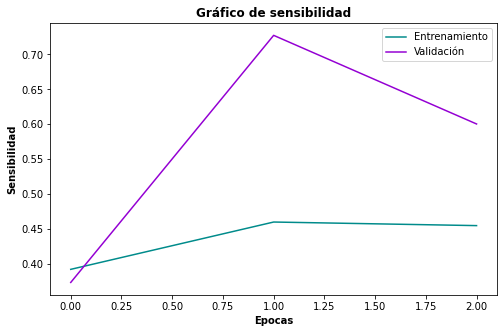

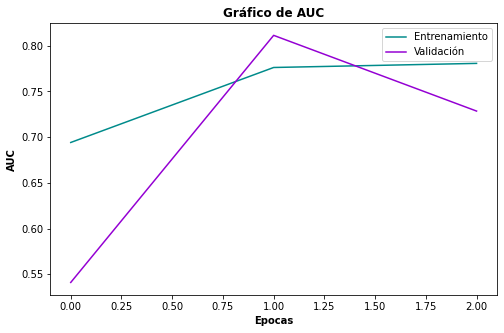

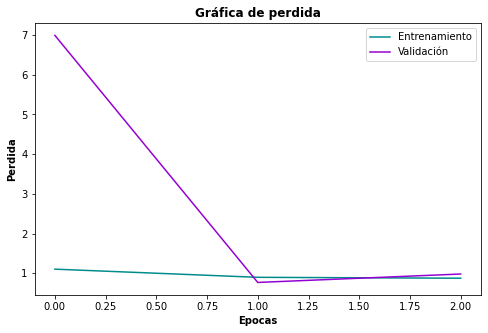

In [21]:
Epocas = range(len(ksst.history['categorical_accuracy']))

# Gráfico de accuracy
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['categorical_accuracy'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_categorical_accuracy'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Exactitud', fontweight = 'bold')
plt.title('Gráfico de exactitud', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de precision
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['precision'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Precisión', fontweight = 'bold')
plt.title('Gráfico de precisión', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de recall
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['recall'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_precision'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Sensibilidad', fontweight = 'bold')
plt.title('Gráfico de sensibilidad', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfico de auc
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['auc'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_auc'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('AUC', fontweight = 'bold')
plt.title('Gráfico de AUC', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

# Gráfica de loss
plt.figure(figsize = (8, 5))
plt.plot(Epocas, ksst.history['loss'], color = 'darkcyan')
plt.plot(Epocas, ksst.history['val_loss'], color = 'darkviolet')
plt.xlabel('Epocas', fontweight = 'bold')
plt.ylabel('Perdida', fontweight = 'bold')
plt.title('Gráfica de perdida', fontweight = 'bold')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

In [22]:
# Evaluación del modelo
# https://stackoverflow.com/questions/63684459/should-i-use-evaluate-generator-or-evaluate-to-evaluate-my-cnn-model
# Se debe usar .fit y .evaluate, porque .fit_generator y .evaluate_generator estan obsoletos
Evaluacion_modelo = modelo2.evaluate(Prueba)
Evaluacion_modelo

25/25 [==============================] - 85s 3s/step - loss: 0.9484 - categorical_accuracy: 0.5025 - precision: 0.6071 - recall: 0.3452 - auc: 0.7412


[0.9483581185340881,
 0.5025380849838257,
 0.6071428656578064,
 0.34517765045166016,
 0.7412294745445251]

In [23]:
print(f'Exactitud del conjunto de prueba: {Evaluacion_modelo[1]*100:.2f}%\n')
print(f'Presición del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n')
print(f'Sensibilidad del conjunto de prueba: {Evaluacion_modelo[3]*100:.2f}%\n')
print(f'Área bajo la curva del conjunto de prueba: {Evaluacion_modelo[2]*100:.2f}%\n')
print(f'Perdida del conjunto de prueba: {Evaluacion_modelo[0]*100:.2f}%')

Exactitud del conjunto de prueba: 50.25%

Presición del conjunto de prueba: 60.71%

Sensibilidad del conjunto de prueba: 34.52%

Área bajo la curva del conjunto de prueba: 60.71%

Perdida del conjunto de prueba: 94.84%


In [24]:
# FALTA CURVA ROC

In [25]:
# Predecir del conjunto del prueba
# Se usa .predict para predecir
Predecir = modelo2.predict(Prueba)
Predecir

25/25 [==============================] - 77s 3s/step


array([[8.11071396e-01, 1.00832425e-01, 8.80961493e-02],
       [9.98503089e-01, 5.97131613e-04, 8.99811275e-04],
       [9.99026299e-01, 6.86861982e-04, 2.86854454e-04],
       ...,
       [3.66444558e-01, 2.79503316e-01, 3.54052097e-01],
       [1.26906604e-01, 2.52780527e-01, 6.20312929e-01],
       [5.87715022e-02, 4.52835619e-01, 4.88392889e-01]], dtype=float32)

In [26]:
# Etiquetas del conjunto de prueba
Prueba.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [27]:
# Clasificación
Clasificacion = np.argmax(Predecir, axis=1)
Clasificacion

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0,
       1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 2,
       1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 2, 0, 2, 1, 0, 2, 1, 0, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1,
       2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 0, 2, 2, 0, 2, 1, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 1, 1, 0, 1, 2, 0, 1,
       0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2,

In [28]:
# Etiqueta de las clases
Entrenamiento.class_indices

{'Normal': 0, 'Benigno': 1, 'Cancer': 2}

In [29]:
# Reporte de clasificación
etiquetas_imagenes = ['Normal', 'Benigno', 'Cancer']

print("Reporte de clasificación:")
print(classification_report(y_true = Prueba.classes, y_pred = Clasificacion,
                            target_names = etiquetas_imagenes))

Reporte de clasificación:
              precision    recall  f1-score   support

      Normal       0.53      0.84      0.65       122
     Benigno       0.43      0.28      0.34       135
      Cancer       0.52      0.42      0.47       137

    accuracy                           0.50       394
   macro avg       0.49      0.51      0.48       394
weighted avg       0.49      0.50      0.48       394



Índices: {'Normal': 0, 'Benigno': 1, 'Cancer': 2} 

Matriz de confusión:
[[102   9  11]
 [ 54  38  43]
 [ 38  41  58]] 



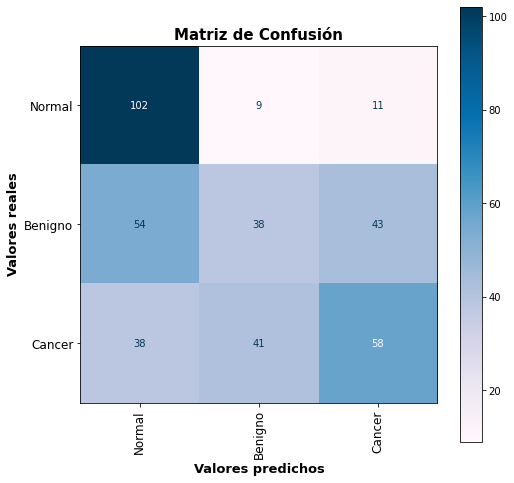



Exactitud: 50.25%

Presición: 50.25%

Sensibilidad: 50.25%

Puntaje F1: 50.25%



In [30]:
# FALTA AGREGAR AUC
# Construcción de matriz de confusión y reporte de clasificación
# https://scikit-learn.org/stable/modules/model_evaluation.html#multiclass-and-multilabel-classification
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
print('Índices:', Entrenamiento.class_indices, '\n')

matriz = confusion_matrix(y_true = Prueba.classes, y_pred = Clasificacion)

print('Matriz de confusión:')
print(matriz, '\n')

disp = ConfusionMatrixDisplay(confusion_matrix = matriz, display_labels = etiquetas_imagenes)
fig, ax = plt.subplots(figsize = (8, 8))
disp = disp.plot(xticks_rotation = 'vertical', ax = ax, cmap = 'PuBu')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('Matriz de Confusión', fontweight = 'bold', fontsize = 15)
plt.xlabel('Valores predichos', fontweight = 'bold', fontsize = 13)
plt.ylabel('Valores reales', fontweight = 'bold', fontsize = 13)
plt.show()

print("\n")
print(f"Exactitud: {accuracy_score(Prueba.classes, Clasificacion)*100:.2f}%\n")
print(f"Presición: {precision_score(Prueba.classes, Clasificacion, average = 'micro')*100:.2f}%\n")
print(f"Sensibilidad: {recall_score(Prueba.classes, Clasificacion, average = 'micro')*100:.2f}%\n")
print(f"Puntaje F1: {f1_score(Prueba.classes, Clasificacion, average = 'micro')*100:.2f}%\n")

In [31]:
# ANTES DE CORRER ESTA LINEA, ASEGURESE DE NO TENER EL MODELO GUARDADO ANTERIORMENTE

# Guardar el modelo
modelo2.save('C:/Git/python/MCD-PCD/MiniProyecto2/Modelo_Mamografia.h5')
# modelo2.save('Modelo_Mamografia.h5')

# Guardar los pesos del modelo
modelo2.save_weights('C:/Git/python/MCD-PCD/MiniProyecto2/Modelo_Mamografia.h5')